In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math as mp

Lecture de notre image et seuillage.

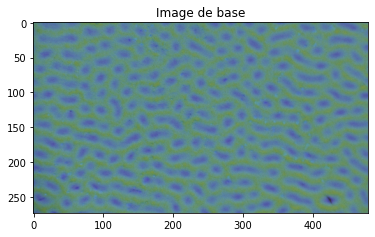

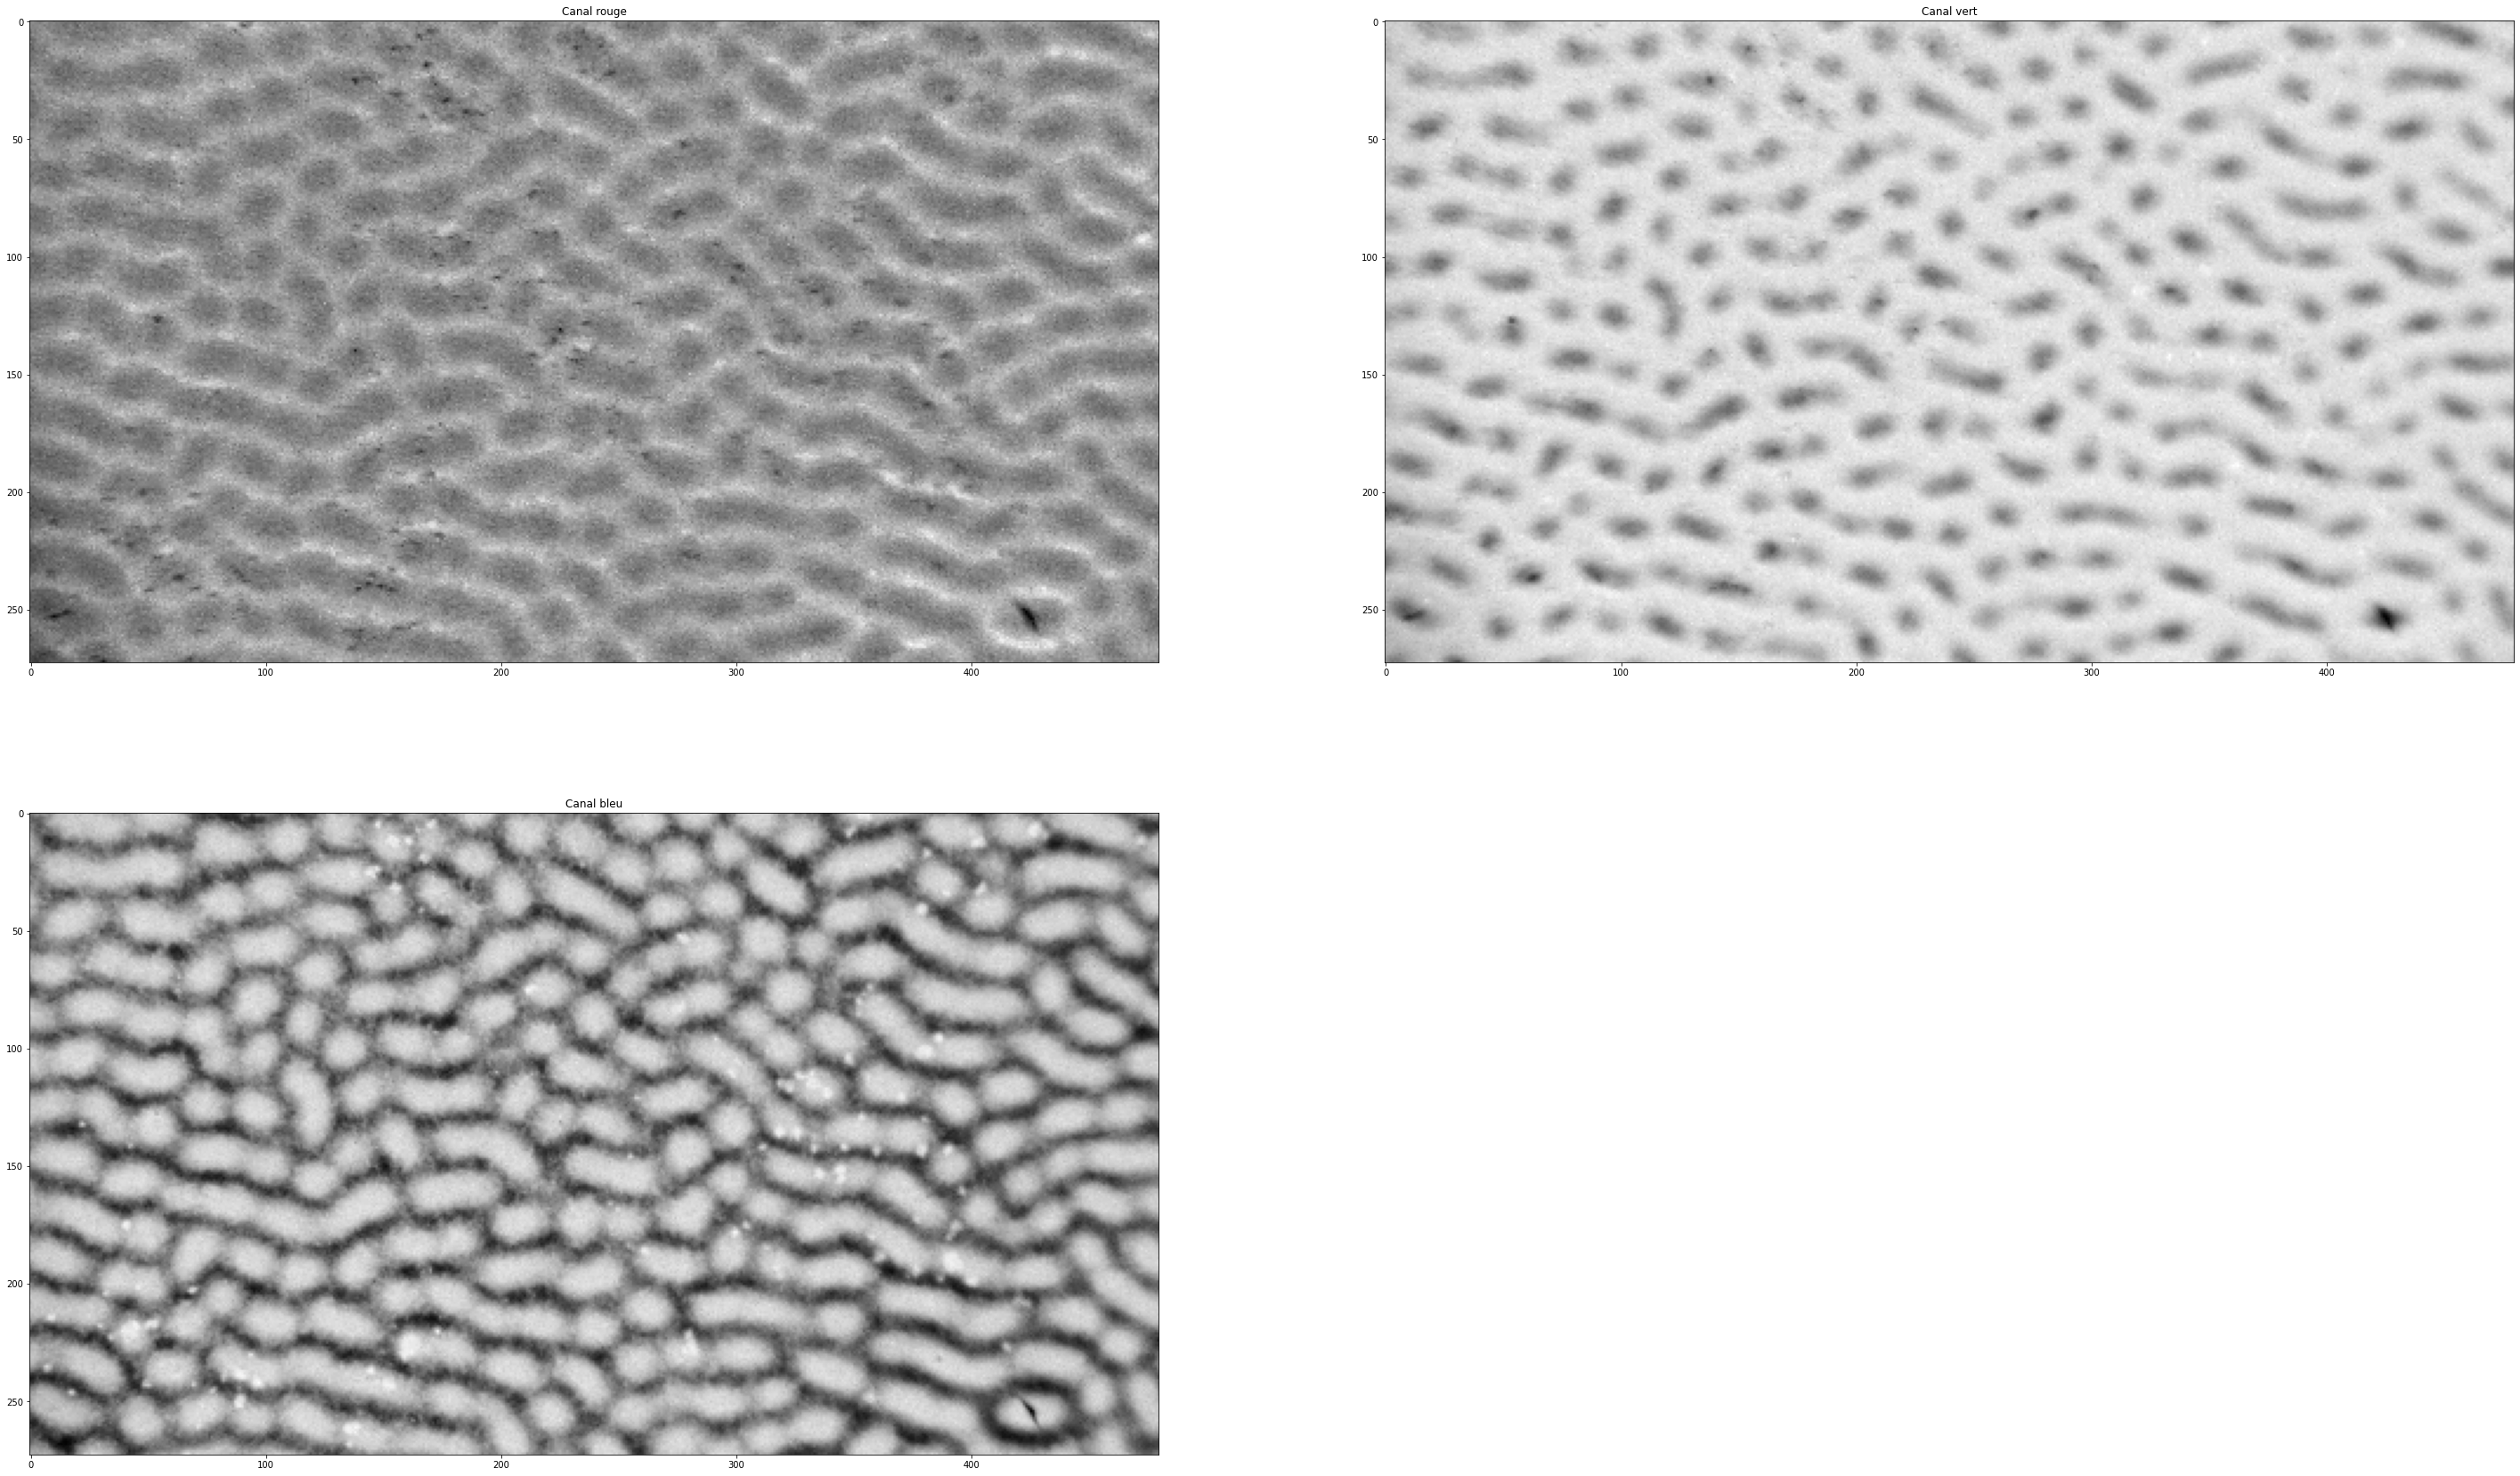

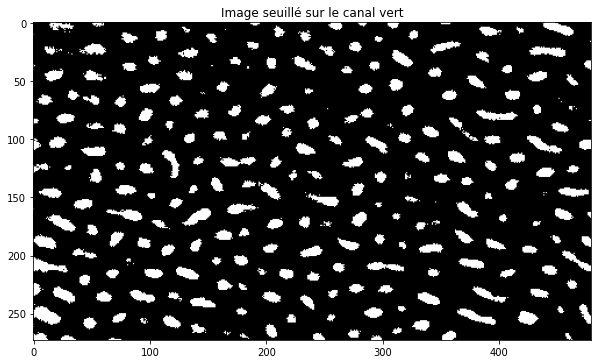

In [2]:
#Lecture de l’image (en niveau de gris)
seuil = 120
seuil2 = 140
image=cv2.imread('perovskyte.png')
I = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image,'gray') # affichage de l'image I en niveau de gris
plt.title("Image de base")
plt.show()


# Separation de l'image
B, G, R = cv2.split(I)

img_g = G 
img_r = R
img_b = B

# Seuillage de la composante verte
imageS = cv2.threshold(img_g, 120, 255, cv2.THRESH_BINARY_INV)

imageSS = imageS[1]

plt.figure(figsize=(50,30)) # ouvre une nouvelle figure
#Affichage des caneaux RGB et des images seuillé et en n & b
plt.subplot(221)
plt.title('Canal rouge')
plt.imshow(R,'gray')

plt.subplot(222)
plt.title('Canal vert')
plt.imshow(G,'gray')

plt.subplot(223)
plt.title('Canal bleu')
plt.imshow(B,'gray')
plt.show()

plt.figure(figsize=(10,10)) # ouvre une nouvelle figure
plt.title('Image seuillé sur le canal vert')
plt.imshow(imageSS,'gray')
plt.show()

#afficher les caneaux rgb et trouver un maniere d'obtenir mon image de marquer dans chaque cellule

Création des marqueurs :

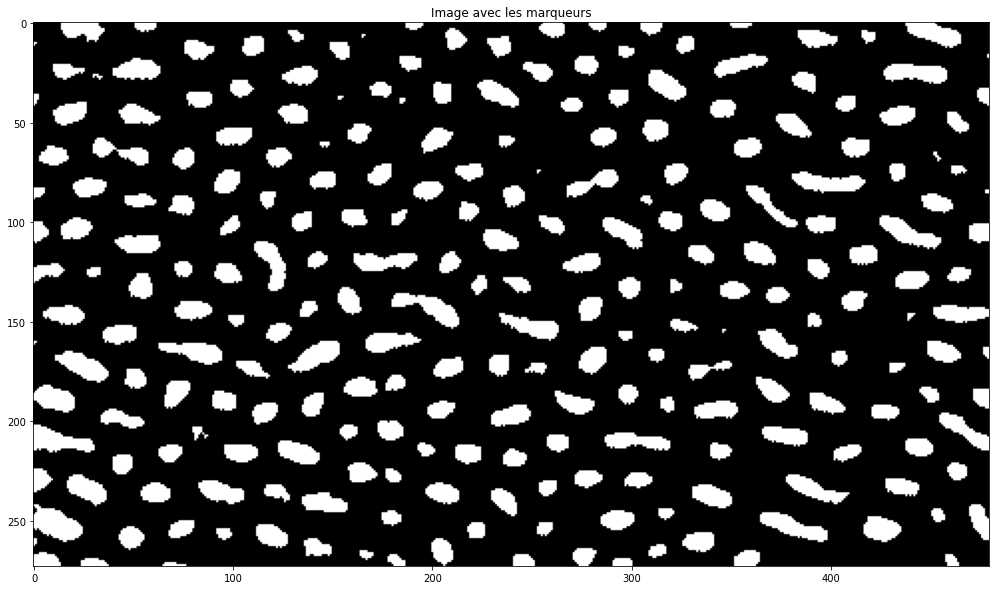

In [3]:
#Isolation d'un marqueur unique dans chaque cellule
# On dilate puis on érode notre image afin d'avoir un label pour chaque cellule
S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)) #création d'un élément structurant circulaire

imageM = cv2.dilate(imageSS, S, iterations = 1) # on dilate notre image
S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) #création d'un élément structurant circulaire
imageM=cv2.erode(imageM, S, iterations = 1) # on érode notre image

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Image avec les marqueurs")
plt.imshow(imageM,'gray') # affichage de l'image I en niveau de gris
plt.show()

Labellisation de mes marqueurs + du fond

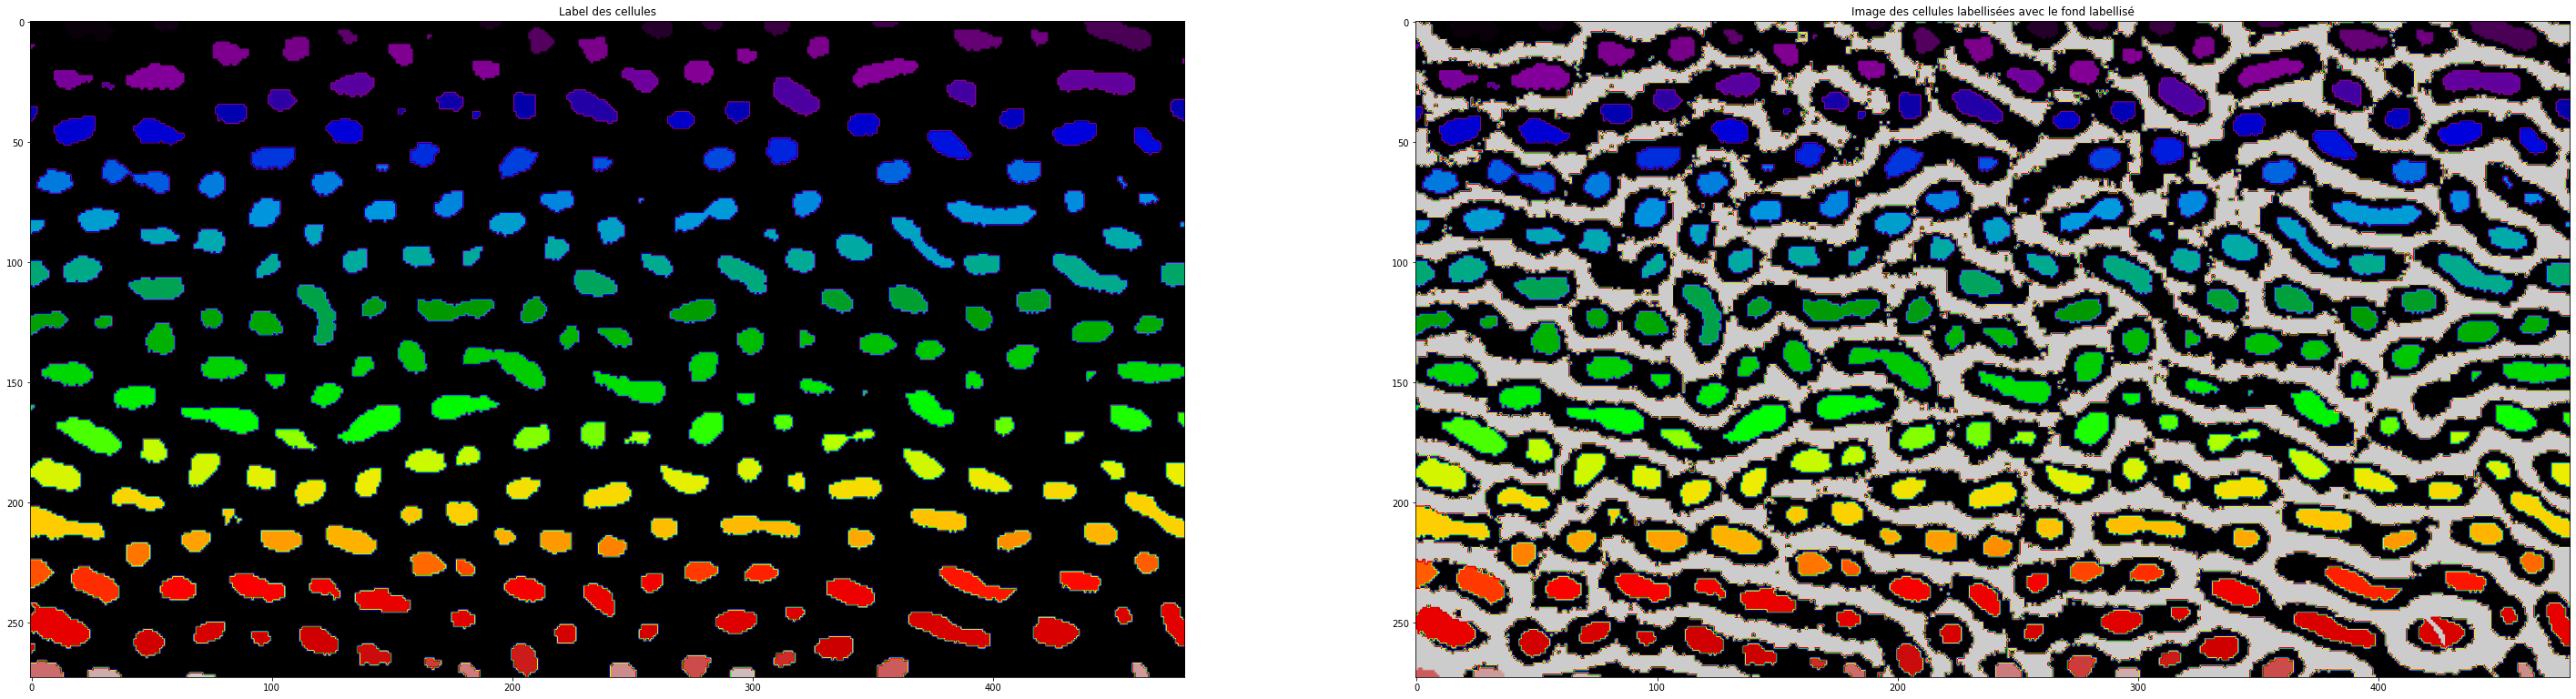

In [4]:
imageML = cv2.connectedComponents(imageM) # on labélise nos marqueur : le fond n'est pas encore labellisé
imageMLL = imageML[1] # on récupère l'image labellisée
u = np.max(imageMLL)


imageF = cv2.threshold(img_b,130,u+1,cv2.THRESH_BINARY_INV) # on prend notre canal bleu, afin de récupérer le fond et on
                                                            # lui donne un label unique
imageFond = imageF[1] 

imageMarqueurs = imageFond+imageMLL # On additionne l'image des labels des cellules et l'image avec le label du fond

# Lors de la réccupération du fond avec le canal bleu, celui ci n'est pas parfait nous touchons un peu les marqueurs
# lors de l'addition nous avons donc des labels supérieur aux label du fond
# nous remettons donc a la main ces pixels en leur donnant le label du fond
k,l = np.shape(imageMarqueurs)
for i in range (k):
    for j in range(l):
        if imageMarqueurs[i][j]>u+1:
            imageMarqueurs[i][j]=u+1


plt.figure(figsize=(50,20))

plt.subplot(121)
plt.title("Label des cellules")
plt.imshow(imageMLL,cmap='nipy_spectral') # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image des cellules labellisées avec le fond labellisé")
plt.imshow(imageMarqueurs,cmap='nipy_spectral') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

Création de la carte des distances

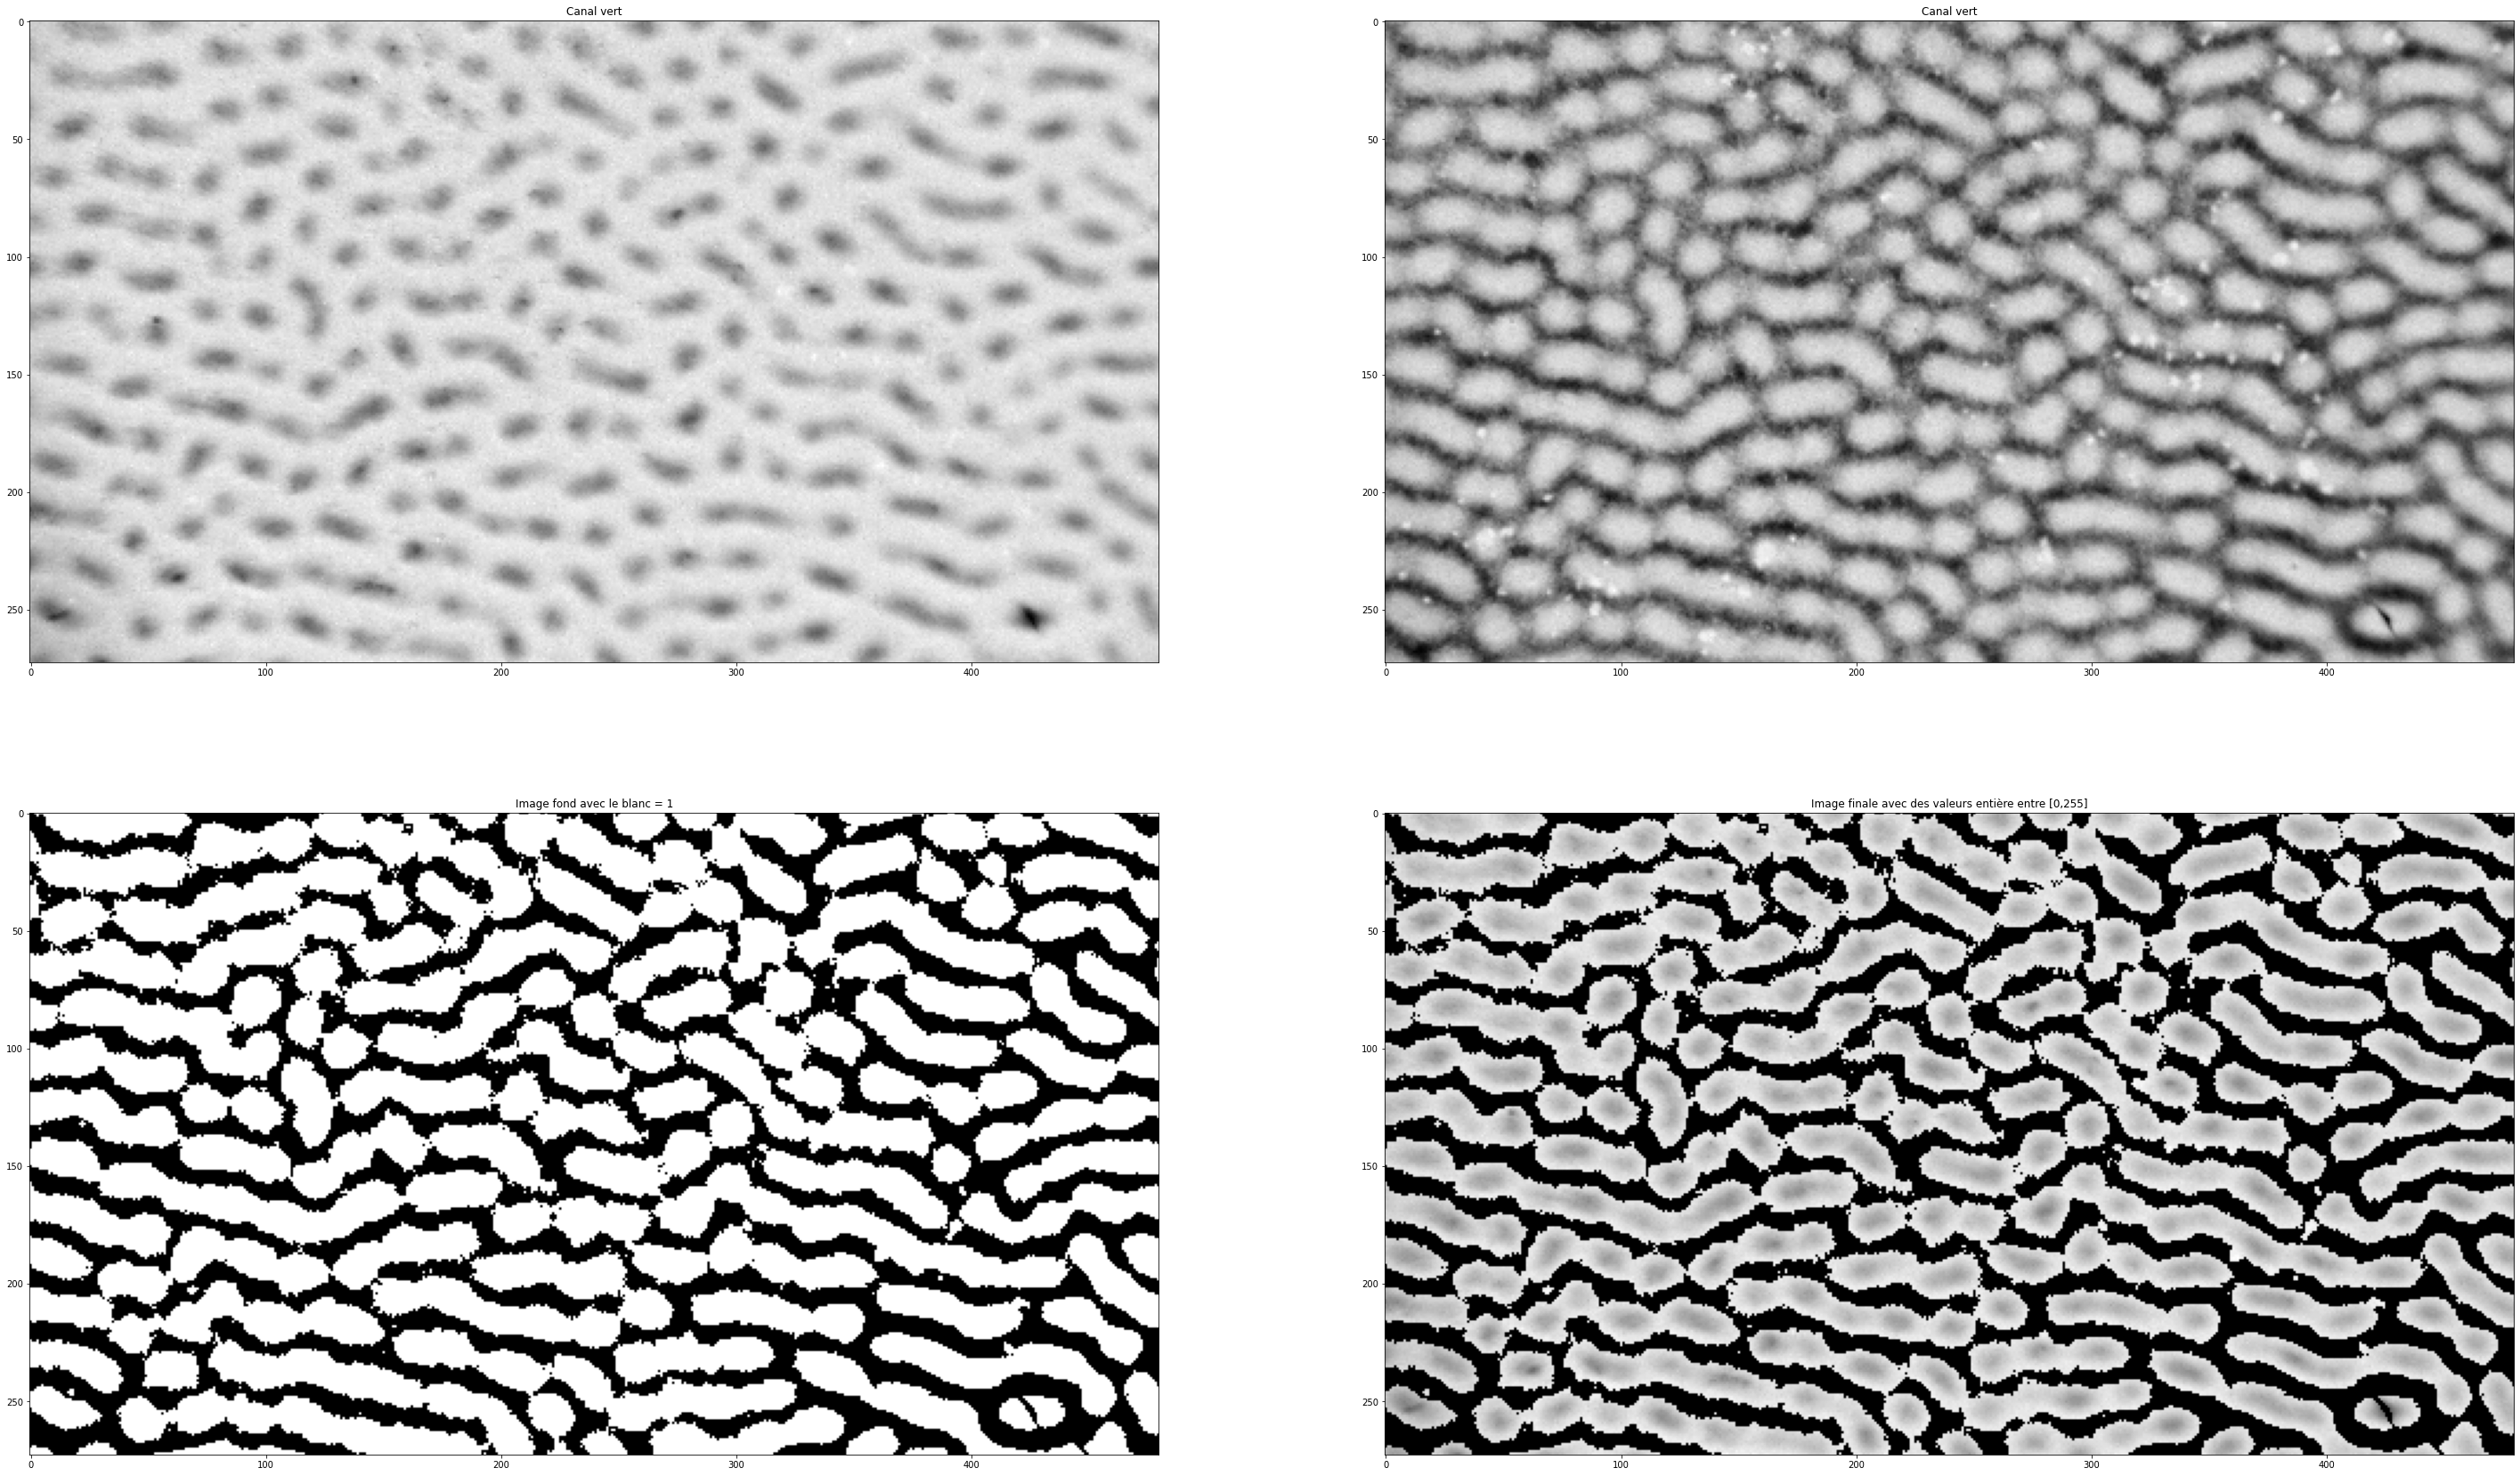

In [5]:
imageF = cv2.threshold(img_b,130,1,cv2.THRESH_BINARY) # on refait le même seuillage de notre canal bleu mais cette fois ci le blanc vaut 1
ImageFin = img_g * imageF[1] # on multiplie notre calnal vert par l'image du fond obtenue

#On normalise l'image obtenue pour l'avoir entre [0,255]
u = np.max(ImageFin)
Imagetempo = ImageFin * (255/u)

#On la met sous forme uint8 donc la matrice ne contient maintenant que des entiers
imageDistFin = np.uint8(Imagetempo)
max2 = np.max(imageDistFin)
min2 = np.min(imageDistFin)



plt.figure(figsize=(50,30))

plt.subplot(221)
plt.title("Canal vert")
plt.imshow(img_g,'gray') # affichage de l'image I en niveau de gris

plt.subplot(222)
plt.title("Canal vert")
plt.imshow(img_b,'gray') # affichage de l'image I en niveau de gris

plt.subplot(223)
plt.title("Image fond avec le blanc = 1")
plt.imshow(imageF[1],'gray') # affichage de l'image I en niveau de gris

plt.subplot(224)
plt.title("Image finale avec des valeurs entière entre [0,255]")
plt.imshow(imageDistFin,'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage


LPE :

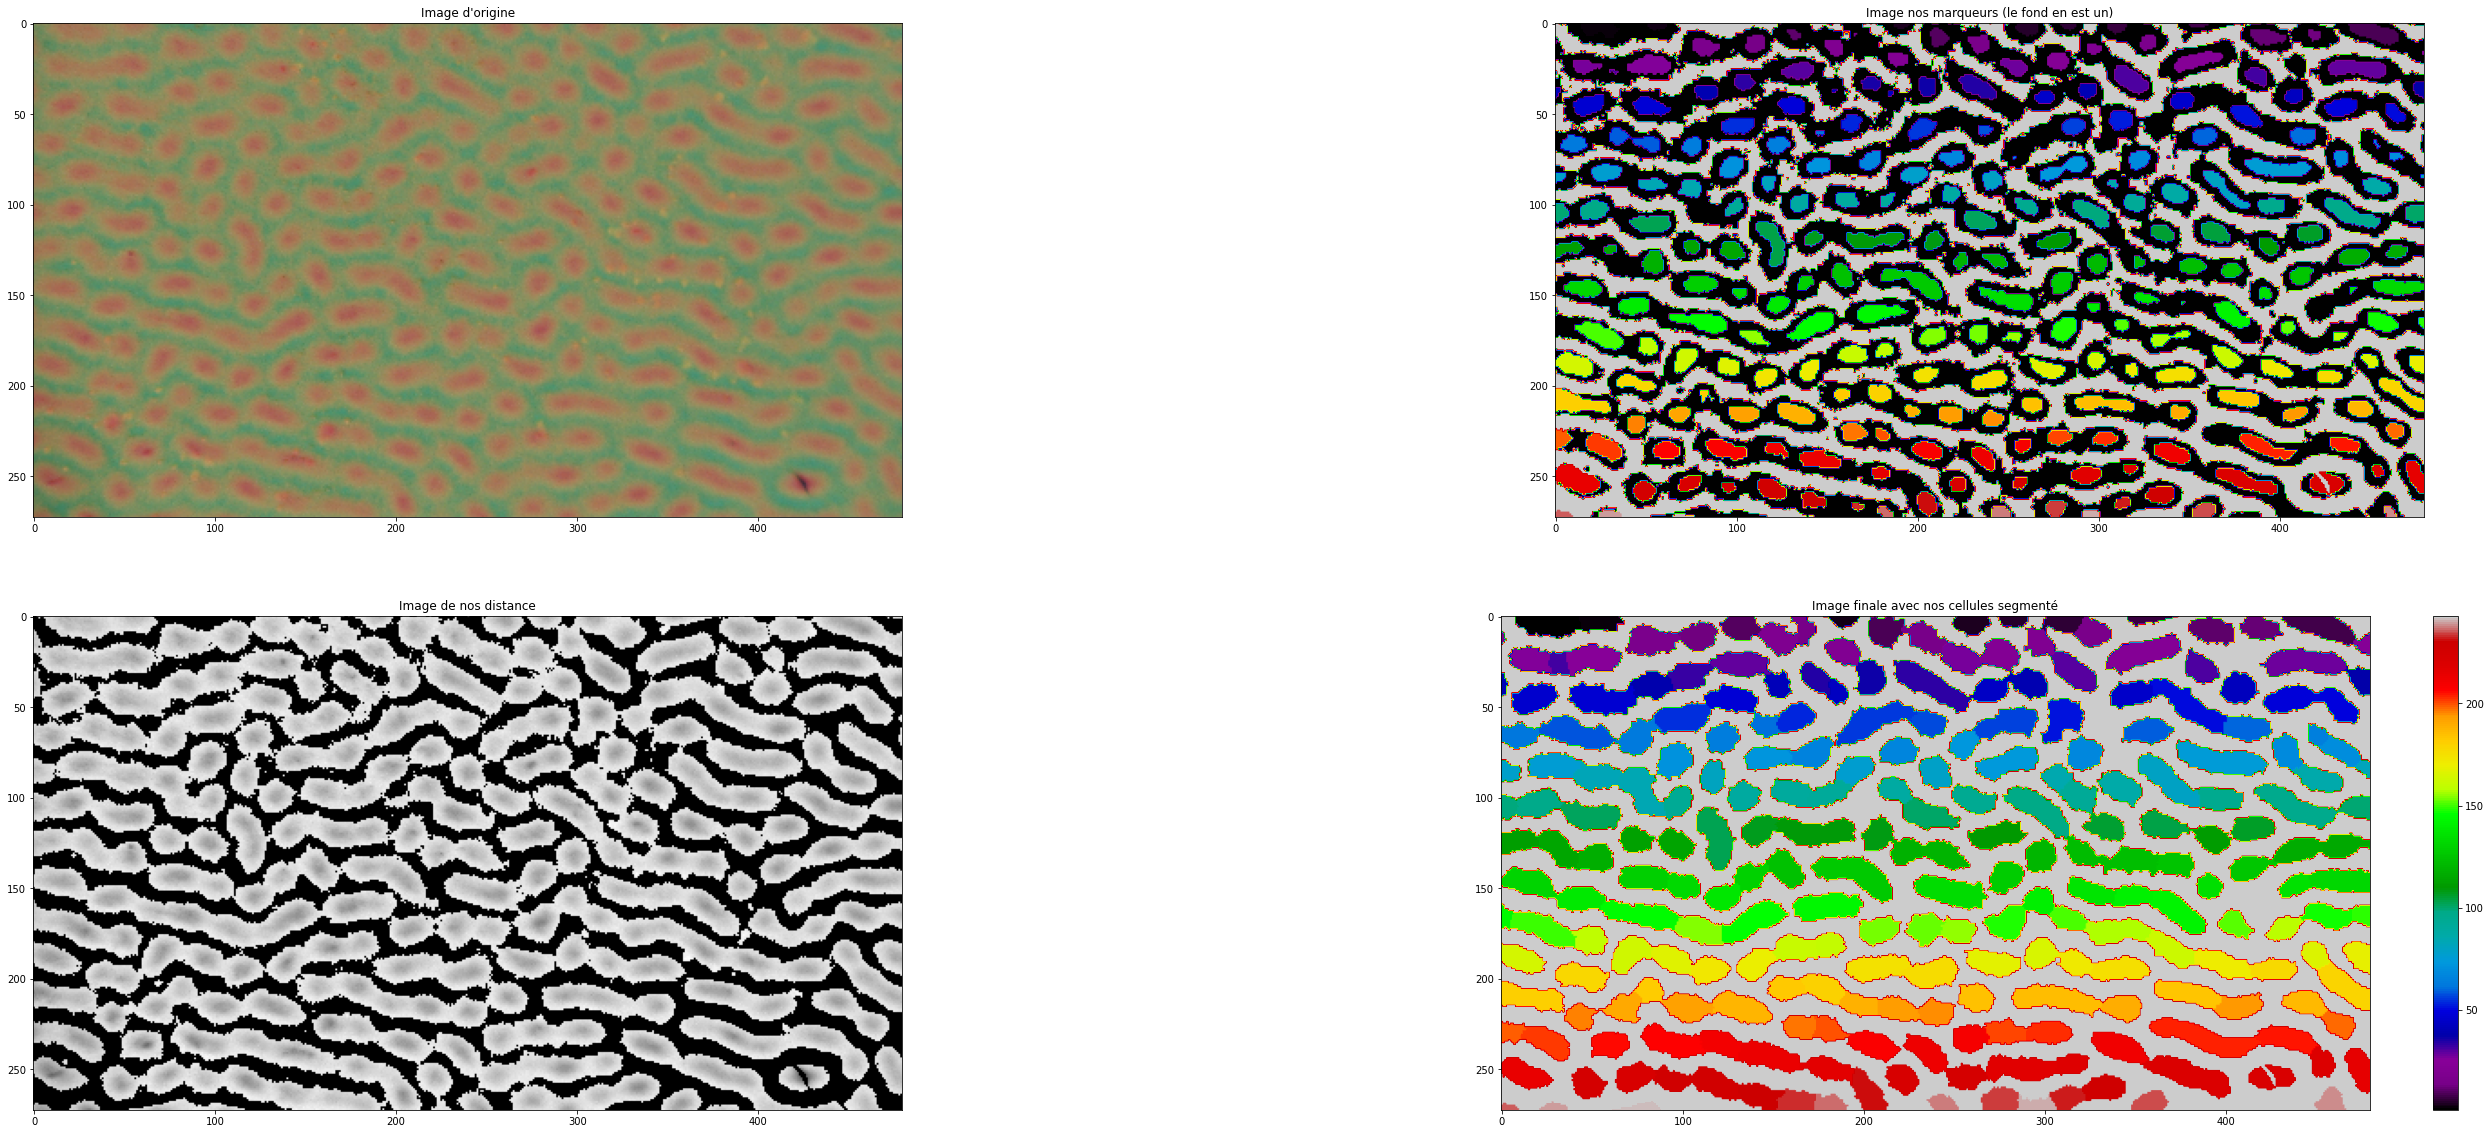

In [6]:
T = np.copy(imageMarqueurs) # On fait une copy de notre image de marqueur pour l'affichage

# On créer notre matrice de prioritée avec 256 colonnes
CoordLigne = [] 
CoordColonne = []
for i in range(256):
    CoordLigne.append([])
    CoordColonne.append([])


taille = imageMarqueurs.shape
TailleLigne = taille[0]
TailleColonne = taille[1]

# Liste des images que nous voulons enregistrée
ImageEnregistree =  {0,20,50,70,100,120,150,170,200,220,255}

for i in range(TailleLigne):
    for j in range(TailleColonne):
        if imageMarqueurs[i][j]!=0 :
            CoordLigne[imageDistFin[i][j]].append(i) # on parcours tous nos marqueurs et on les rangent selon leur priorité dans CoordLigne et CoordColonne
            CoordColonne[imageDistFin[i][j]].append(j)

min = 0
while min!=256 : # Tant que l'on a pas parcouru toutes les colonnes de CoordLigne donc tous les niveaux de priorité
    if CoordLigne[min]: # Si il y a des pixels à traiter dans la la colonne de priorités min on fait ce qui suit sinon on augment min et au passe a la priorité suivante
        while CoordLigne[min]: # Tant qu'il y a des pixels à traiter dans la colonne de priorité min
            i = CoordLigne[min].pop(0)
            j = CoordColonne[min].pop(0) # on récupère les 2 corrdonées de notre prixels

            # On regarde ses 4 voisins, si un voisin n'a pas de label, on lui attribut le label du pixel récupérer et on range les coordonnées de se nouveau pixel selon leur priorité dans CoordLigne et CoordColonne
            if(i<TailleLigne-1):
                if T[i+1][j]==0:
                    T[i+1][j]=T[i][j]
                    u = imageDistFin[i+1][j] # Si la prioritée du nouveaux pixel est inférieur à min on lui donne une nouvelle prioriée : min (car on ne repassera pas dans les colonnes qui ont déjà été traité entièrement)
                    CoordLigne[np.max([u,min])].append(i+1)
                    CoordColonne[np.max([u,min])].append(j)
                
            if(j<TailleColonne-1):
                if T[i][j+1]==0:
                    T[i][j+1]=T[i][j]
                    u = imageDistFin[i][j+1]
                    CoordLigne[np.max([u,min])].append(i)
                    CoordColonne[np.max([u,min])].append(j+1)

            if(i!=0) :
                if T[i-1][j]==0:
                    T[i-1][j]=T[i][j]
                    u = imageDistFin[i-1][j]
                    CoordLigne[np.max([u,min])].append(i-1)
                    CoordColonne[np.max([u,min])].append(j)

            if(j!=0):
                if T[i][j-1]==0:
                    T[i][j-1]=T[i][j]
                    u = imageDistFin[i][j-1]
                    CoordLigne[np.max([u,min])].append(i)
                    CoordColonne[np.max([u,min])].append(j-1)
    else : 
        if min in ImageEnregistree :
            im1 = plt.imsave("{}.png".format(min), T,cmap='nipy_spectral')
        min+=1


plt.figure(figsize=(50,20))


plt.subplot(221)
plt.title("Image d'origine")
plt.imshow(I,'gray') # affichage de l'image I en niveau de gris


plt.subplot(222)
plt.title("Image nos marqueurs (le fond en est un)")
plt.imshow(imageMarqueurs,cmap='nipy_spectral') # affichage de l'image I en niveau de gris

plt.subplot(223)
plt.title("Image de nos distance")
plt.imshow(imageDistFin,'gray') # affichage de l'image I en niveau de gris

plt.subplot(224)

plt.title("Image finale avec nos cellules segmenté")
plt.imshow(T, cmap='nipy_spectral') # affichage de l'image I en niveau de gris
plt.colorbar()
plt.show() # déclenche l'affichage